In [16]:
import base64
import io
from PIL import Image

base_width = 300
img = Image.open('../data/images/lawn_image.jpg')
wpercent = (base_width / float(img.size[0]))
hsize = int((float(img.size[1]) * float(wpercent)))
img = img.resize((base_width, hsize), Image.Resampling.LANCZOS)

img_byte_arr = io.BytesIO()
img.save(img_byte_arr, format='jpeg')
img_byte_arr = img_byte_arr.getvalue()
image_data = base64.b64encode(img_byte_arr).decode("utf-8")


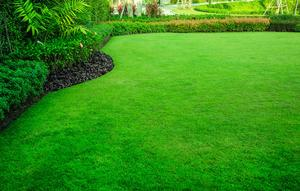

In [19]:
from PIL import Image
import io
import base64

img = Image.open(io.BytesIO(base64.b64decode(image_data)))
img


In [20]:
import dotenv
# import os
dotenv.load_dotenv(override=False)
# OPENAI_API_KEY = os.environ.get("OPENAI_API_KEY")

True

In [21]:
from langchain_core.prompts import ChatPromptTemplate
from langchain_openai import ChatOpenAI

model = ChatOpenAI(model="gpt-4o")

In [22]:
from langchain_core.pydantic_v1 import BaseModel, Field
from typing import List
class ImageTags(BaseModel):
    """Binary score to assess answer addresses question."""
    image_description: str = Field(name="image_description",
        description="Short image description"
    )
    extracted_tags: List[str] = Field(name="list_tags",
        description="Tags present in the image from list ['Wet Grass', 'Thin trees', 'Pavement', 'Farm','Short grass','Thick grass','Dry grass,'stones','Garden','Building']"
    )

In [23]:
prompt = ChatPromptTemplate.from_messages(
    [
        (
            "user",
            [
                {
                    "type": "image_url",
                    "image_url": {"url": "data:image/jpeg;base64,{image_data}"},
                }
            ],
        ),
    ]
)

structured_llm_grader = model.with_structured_output(ImageTags)
img_parser = prompt | structured_llm_grader
output = img_parser.invoke(image_data)

In [24]:
print(output.extracted_tags)

['Garden', 'Short grass']


In [25]:
print(output.image_description)

A well-maintained garden with lush green grass and surrounding plants.


In [28]:
import pandas as pd

acs_df = pd.read_csv('../data/stihl/product_accesories.csv')
new_products = pd.read_csv('../data/stihl/stihl_new_products.csv')

,accessory_link,accessory_image,accessory_name,accessory_description,Tags
0,https://www.stihlusa.com/products/trimmers-and...,https://stihlusa-images.imgix.net/Product/786/...,AutoCut Line Heads,Mowing head that uses nylon line. Advances cut...,"Wet Grass, Garden"
1,https://www.stihlusa.com/products/trimmers-and...,https://stihlusa-images.imgix.net/Product/791/...,AutoCut EasySpool™ Line Heads,These AutoCut® cutting heads with EasySpool™ a...,"Pavement, Building"
2,https://www.stihlusa.com/products/trimmers-and...,https://stihlusa-images.imgix.net/Product/794/...,Brush Knife,"With a steel triple blade, this brush knife is...",Thick grass
3,https://www.stihlusa.com/products/trimmers-and...,https://stihlusa-images.imgix.net/Product/797/...,Circular Saw Blade - Chisel Tooth,For sawing and clearing of gnarled bushes and ...,Thin trees
4,https://www.stihlusa.com/products/trimmers-and...,https://stihlusa-images.imgix.net/Product/792/...,STIHL SuperCut™ Line Head,STIHL SuperCut™ features fully automatic line ...,Farm


In [35]:
from pathlib import Path

from llama_index.readers.file import PagedCSVReader
from llama_index.core import VectorStoreIndex

loader = PagedCSVReader(encoding="utf-8")
documents = loader.load_data(file=Path("../data/stihl/product_accesories.csv"))

In [59]:
index = VectorStoreIndex.from_documents(documents=documents)
query_engine = index.as_query_engine()
retriever = index.as_retriever()
response = query_engine.query("Documents where Tags match are in the list ['Thin trees', 'Dry grass']")
print(response)

There are no documents in the list with tags that match 'Thin trees' or 'Dry grass'.


In [61]:
for item in response.source_nodes:
    product = item.text.split('accessory_name:')[1].split('\n')[0]
    tags = item.text.split('Tags:')[1]
    print(f"Product = {product}, Tags = {tags}")


Product =  Grass Cutting Blade, Tags =  Thick grass, dry grass
Product =  Brush Knife, Tags =  Thick grass


In [56]:
print(item.text.split('accessory_name:')[1].split('\n')[0])

 Brush Knife


## langchain CSV loader

In [1]:
from unstructured.partition.csv import partition_csv
from typing import Any
from langchain_core.pydantic_v1 import BaseModel


class Element(BaseModel):
    type: str
    text: Any
    source: str

import dotenv
# import os
dotenv.load_dotenv(override=False)

True

In [2]:
table_elements = []
raw_tables = partition_csv(filename='../data/stihl/product_accesories.csv')
for table in raw_tables:
                    table_elements.append(Element(type="table", text=str(table), source=table.metadata.filename))

In [9]:
import os
os.chdir('/Users/ajinkya/Documents/startup/agent_hackathon/agents-hackathon')
print(os.getcwd())

from langchain import hub
from langchain_groq import ChatGroq

# LLM
# llm = ChatOpenAI(model_name="gpt-4o", temperature=0, streaming=True)
llm = ChatGroq(model_name="llama3-70b-8192", temperature=0.2, streaming=False)
# llm = ChatGroq(temperature=0, model="gemma2-9b-it", streaming=False)

prompt = hub.pull("rlm/rag-prompt")

# Chain
rag_chain = prompt | llm

# Run
question = "Products where Tags match are in the list ['Thin trees', 'Dry grass']"
docs = table_elements[0].text.strip()
response = rag_chain.invoke({"context": docs, "question": question})
print(response.content)

/Users/ajinkya/Documents/startup/agent_hackathon/agents-hackathon
The products where Tags match are the Circular Saw Blade - Chisel Tooth and the Grass Cutting Blade, which are suitable for cutting "Thin trees" and "Dry grass", respectively.


In [21]:
str(raw_tables[0]).strip()

'accessory_link\naccessory_image\naccessory_name\naccessory_description\nTags\n\n\nhttps://www.stihlusa.com/products/trimmers-and-brushcutters/trimmer-heads-and-blades/autocut/?aqid=7cc82ad014514d263bcc251fea31117b\nhttps://stihlusa-images.imgix.net/Product/786/autocut.png?w=300&h=300\nAutoCut Line Heads\nMowing head that uses nylon line. Advances cutting line when "tapped" against the ground at full throttle.\\n Models include: AutoCut 2-2, 5-2, 11-2, 27-2, 36-2, 46-2, 56-2\nWet Grass, Garden\n\n\nhttps://www.stihlusa.com/products/trimmers-and-brushcutters/trimmer-heads-and-blades/autocutc/?aqid=7cc82ad014514d263bcc251fea31117b\nhttps://stihlusa-images.imgix.net/Product/791/autocutc.png?w=300&h=300\nAutoCut EasySpool™ Line Heads\nThese AutoCut® cutting heads with EasySpool™ and TapAction™ are made for fast-loading residential trimming.\\n  \\n Models include: AutoCut C 4-2, C 6-2, C 26-2\nPavement, Building\n\n\nhttps://www.stihlusa.com/products/trimmers-and-brushcutters/trimmer-heads